In [1]:
!git clone https://github.com/Maadi5/pytorch-triplet-loss.git

Cloning into 'pytorch-triplet-loss'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 298 (delta 111), reused 121 (delta 53), pack-reused 108
Receiving objects: 100% (298/298), 57.46 MiB | 17.67 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [2]:
%cd /content/pytorch-triplet-loss

/content/pytorch-triplet-loss


In [3]:
import torch
import json
import itertools
from torch.utils.data import DataLoader
from torchvision.datasets import EMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torchsummary import summary
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
from collections import OrderedDict
import itertools

from TNN import Mining, default_model, modified_resnet
from TNN.Plot import scatter
from TNN.Loss_Fn import triplet_loss

from TNN import util

In [4]:
config = json.load(open("./config/config1.json"))

In [5]:
device = torch.device('cuda') #cpu

## Train

In [6]:
tsne = TSNE(random_state=0)
batch_size_train = 128

In [7]:
mine_hard = config['hard']      #options: True or False
model_arch = config['model_arch']  #options: 'def' or 'resnet'
margin= config['margin']       #based on experimentation, ideal value is 0.4
split_classes = config['split_classes']    #number of classes to learn on: def 20
label_classes = config['all_labels']
lr = config['lr']             #def 0.0001

output_size = config['output_size']        #curr: 64

seta, setb = util.split_label_class(label_classes, split_classes)

In [8]:
train_loader = DataLoader(EMNIST('./EMNIST/', train=True, download=True,split = 'letters',
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(EMNIST('./EMNIST/', train=False, download=True, split = 'letters',
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=batch_size_train, shuffle=True)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/EMNIST/raw/gzip.zip to ./EMNIST/EMNIST/raw


In [9]:
x_test, y_test = next(iter(test_loader))
x_test = x_test.to(device)
y_test = y_test.to(device)

In [10]:
x_train, y_train = next(iter(train_loader))
x_train = x_train.to(device)
y_train = y_train.to(device)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casti

IS IT EVEN WORKING WTF
(27, 3)
IS IT EVEN WORKING WTF
(27, 3)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


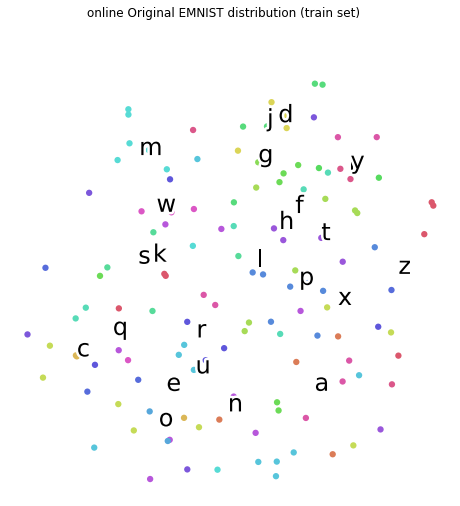

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


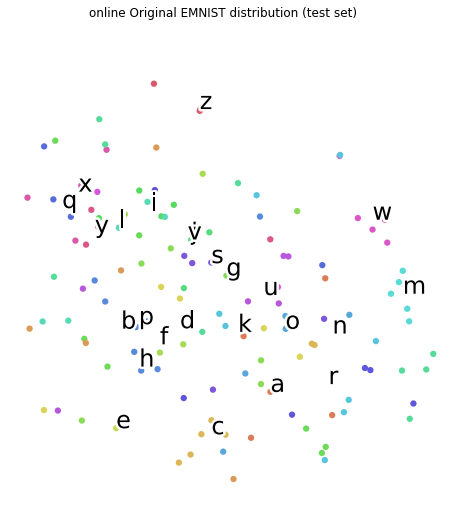

In [11]:
train_tsne_embeds = tsne.fit_transform(x_train.flatten(1).cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(x_test.flatten(1).cpu().detach().numpy())

scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'online Original EMNIST distribution (train set)', dataset='EMNIST')
scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'online Original EMNIST distribution (test set)', dataset='EMNIST')

In [12]:
%cd /content/drive/My Drive/triplet_loss_weights

[Errno 2] No such file or directory: '/content/drive/My Drive/triplet_loss_weights'
/content/pytorch-triplet-loss


In [13]:
if model_arch == 'def':
  model = default_model.TNN(input_shape=x_train.shape[1:], output_size=output_size)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
elif model_arch == 'resnet':
  model = modified_resnet.resnet18(input_shape=x_train.shape[1:], output_size=output_size)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
elif model_arch == 'hybrid_net':
  model = modified_resnet.hybrid18(input_shape=x_train.shape[1:], output_size=output_size, layers=[2,1,2,1])
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)



for epoch in range(0, 100):  # loop over the dataset multiple times
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        l2_ = util.get_lbl_val(label_classes, setb) 
        index_remove = util.find_index_elementlist(labels, l2_)
        inputs = np.delete(inputs, index_remove, axis = 0)
        labels = np.delete(labels, index_remove, axis = 0)

        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        if mine_hard == True:
          loss, pos_triplet, valid_triplet, _ = Mining.online_mine_hard(labels, outputs, margin=margin, squared=True, device=device)
        else:
          loss, pos_triplet, valid_triplet, _ = Mining.online_mine_all(labels, outputs, margin=margin, squared=True, device=device)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    # if epoch%40 == 0:
    #   if mine_hard==True:
    #     torch.save(model.state_dict(), 'triplet_loss_emnist_'+str(margin) + '_epoch: '+str(epoch) + '_out: '+ str(output_size)  +'_'+ model_arch + '_hard_' + '20_chars.pt')
    #   else:
    #     torch.save(model.state_dict(), 'triplet_loss_emnist_'+str(margin) + '_epoch: '+str(epoch) + '_out: '+ str(output_size)  +'_'+ model_arch + '20_chars.pt')

    valid_loss = Mining.valid_loss(model, margin, test_loader, mine_hard, setb)
    print(" "*100)
    print(f"At epoches = {epoch}, epoch_loss = {epoch_loss}", 'epoch_validation_loss: ', valid_loss)


torch.save(model.state_dict(), 'config1_model.pt')
print('Finished Training')

NameError: ignored

### Save Config & final_weights

In [ ]:
#CREATE DICTIONARY WITH N SAMPLES OF IMAGES FROM UNSEEN CLASS
sample_size = 20

test_loader2 = DataLoader(EMNIST('./EMNIST/', train=False, download=True, split = 'letters',                 
                                transform=Compose([ToTensor(),Normalize((0.1307,), (0.3081,))])
                               ),batch_size=1, shuffle=True)
req_dataset = {}
l2_ = util.get_lbl_val(label_classes, setb)
for i, data in enumerate(test_loader2, 0):
    # get the inputs
    input, label = data
    if label in l2_:
      label = int(label)
      if label not in req_dataset.keys():
        req_dataset[label] = []
      if len(req_dataset[label])<sample_size:
        req_dataset[label].append(np.array(input).tolist())

In [ ]:
config = {}
config['hard'] = mine_hard
config['lr'] = lr
config['model_arch'] = model_arch  #options: 'def' or 'resnet'
config['margin'] = margin
config['split_classes'] = split_class
config['output_size'] = output_size
config['all_labels'] = label_classes
config['seta'] = seta
config['setb'] = setb
config['constructed_dataset'] = req_dataset

with open('config.json', 'w') as outfile:
  json.dump(config, outfile)

## Test model

In [18]:
req_dataset = config['constructed_dataset']
seta = config['seta']
setb = config['setb']

print("Letters trained on: ", seta)
print("Letters unseen: ", setb)

Letters trained on:  ['a', 'o', 't', 's', 'i', 'z', 'x', 'j', 'b', 'r', 'k', 'q', 'f', 'p', 'w', 'h', 'v', 'y', 'c', 'l']
Letters unseen:  ['d', 'e', 'g', 'm', 'n', 'u']


In [ ]:
model = modified_resnet.resnet18(input_shape=torch.Size([1, 28, 28]), output_size=output_size)
model.to(device)
model.load_state_dict(torch.load('./config/config1_weights.pt'))
model.eval()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casti

IS IT EVEN WORKING WTF
(27, 3)
IS IT EVEN WORKING WTF
(27, 3)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


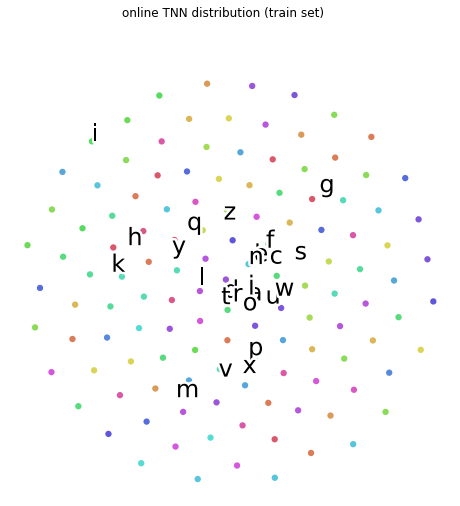

posx and posy should be finite values
posx and posy should be finite values


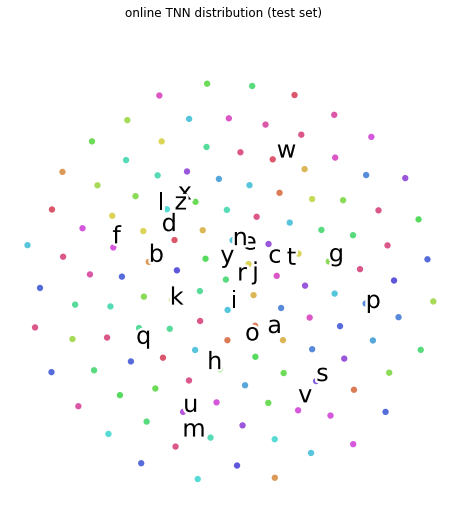

In [30]:
#Visualize untrained characters

train_outputs = model(x_train)
test_outputs = model(x_test)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'online TNN distribution (train set)', dataset= 'EMNIST')
scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'online TNN distribution (test set)', dataset='EMNIST')

In [ ]:
# CALCULATE AVERAGE INTRA-CLASS DISTANCE AND SAVE AS THRESHOLD
dists_ = {}
avg_intra_dist = util.AverageMeter()

for i in setb:
  encoded = util.get_lbl_val(label_classes, [i])[0]
  conc = req_dataset[encoded][0].cuda()
  for j in range(1, sample_size):
    i1 = req_dataset[encoded][j].cuda()
    conc = torch.cat((conc,i1),0).cuda()
  embeddings = model(conc)
  dists = _pairwise_distances(embeddings, squared=True, device=device)
  dist = dists.cpu().detach()
  print(i, torch.mean(dist))
  mean_dist = float(torch.mean(dist))
  avg_intra_dist.update(mean_dist)

print('Threshold difference: ', avg_intra_dist.avg)

d tensor(0.6066)
e tensor(0.3130)
g tensor(0.2878)
m tensor(0.9361)
n tensor(0.4534)
u tensor(0.4662)


AttributeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


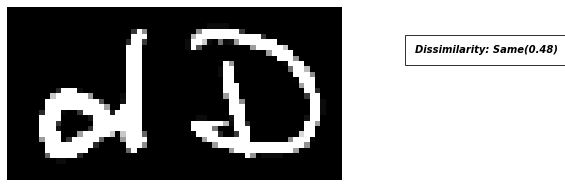

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


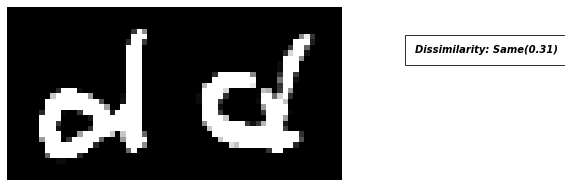

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


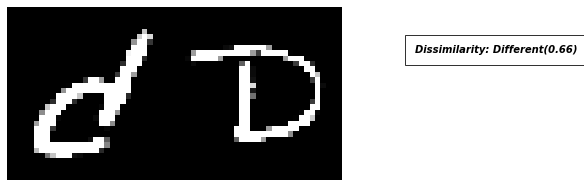

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


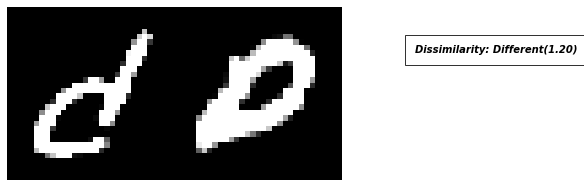

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


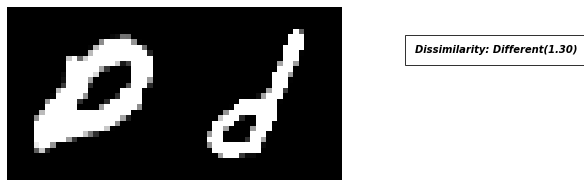

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


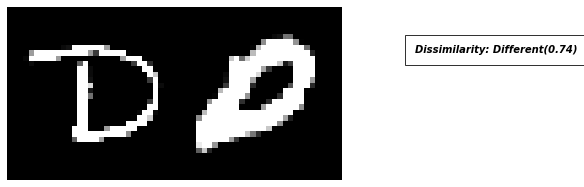

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


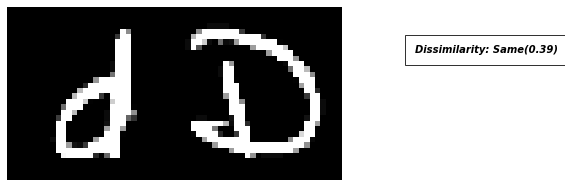

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


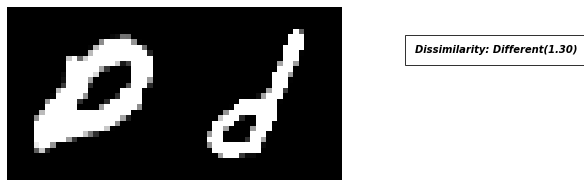

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


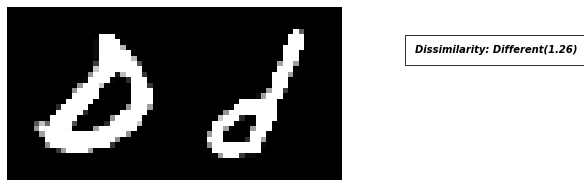

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


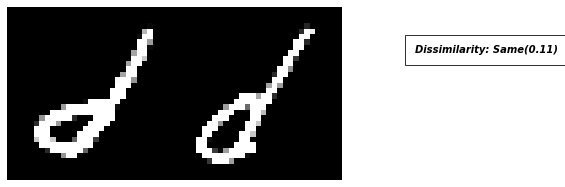

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


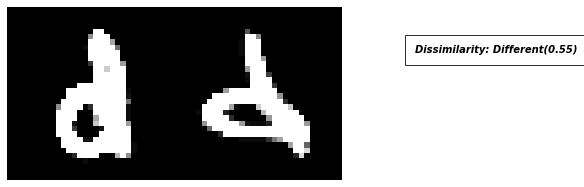

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


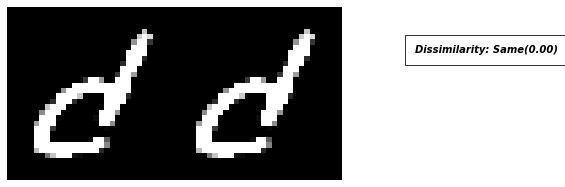

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


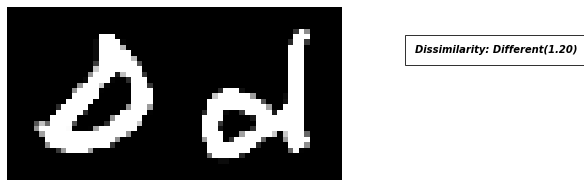

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


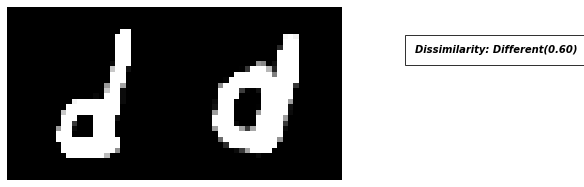

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


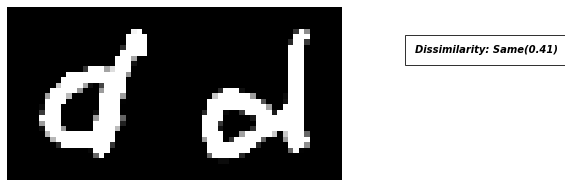

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


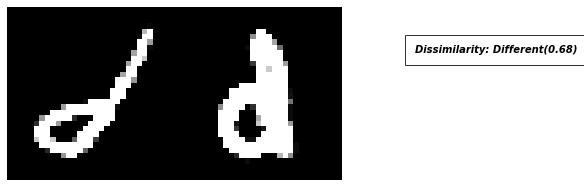

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


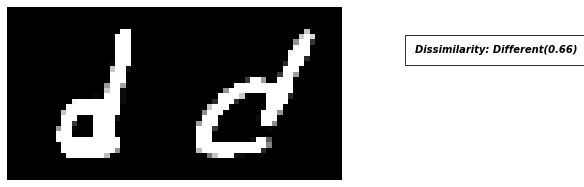

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


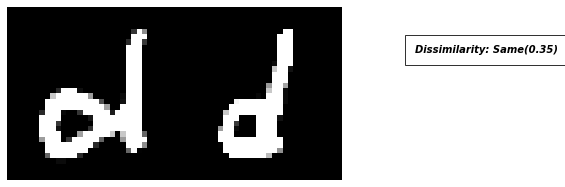

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


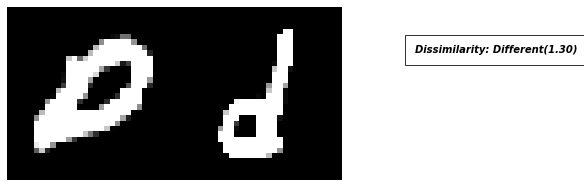

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


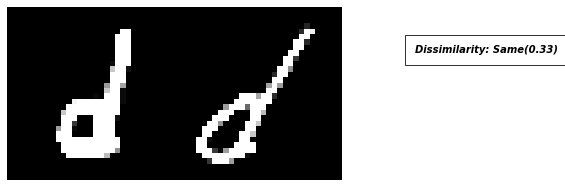

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


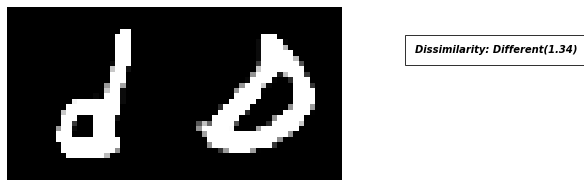

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


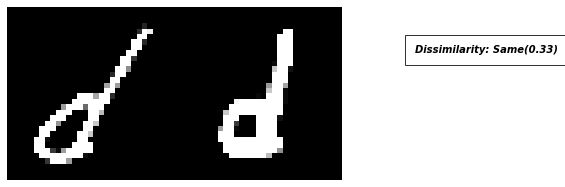

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


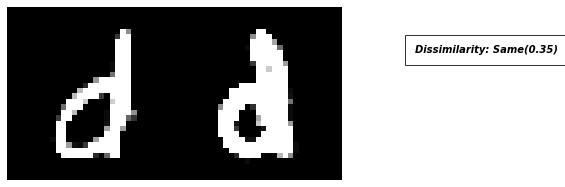

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


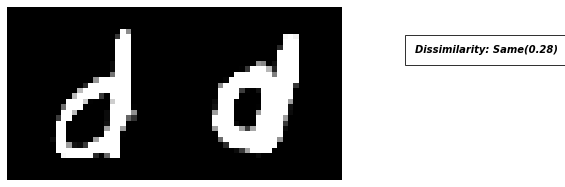

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


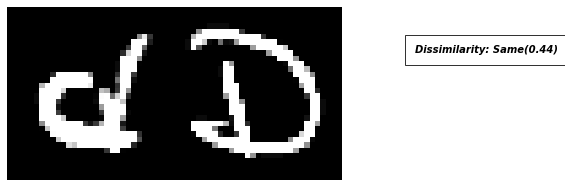

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


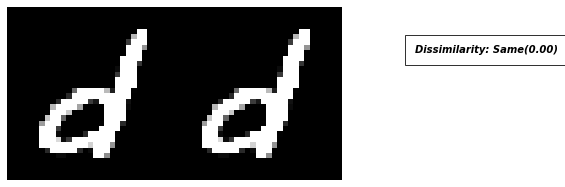

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


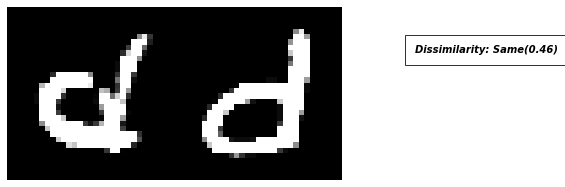

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


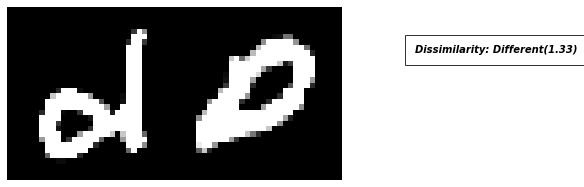

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


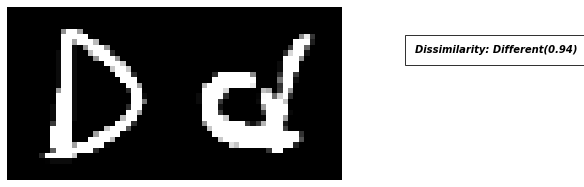

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


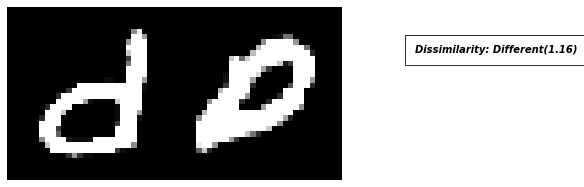

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


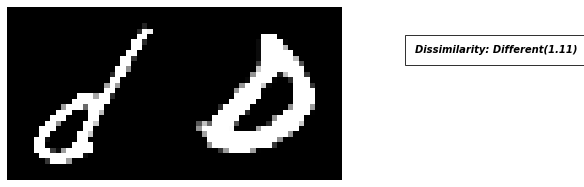

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


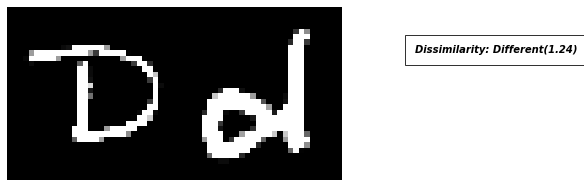

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


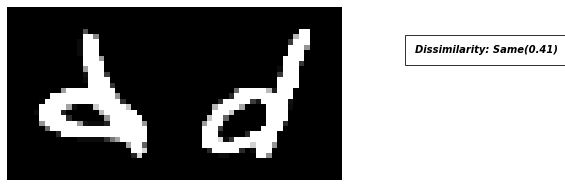

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


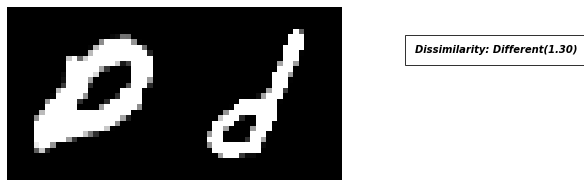

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


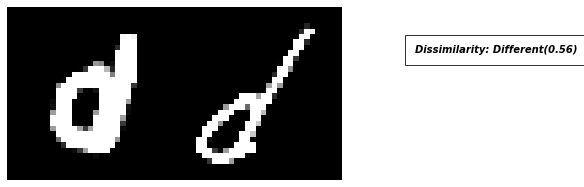

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


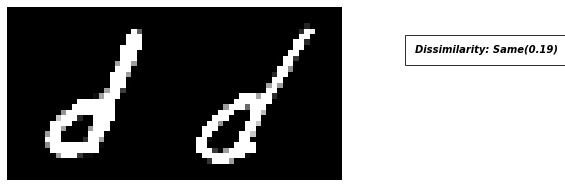

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


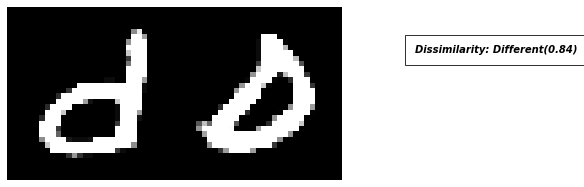

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


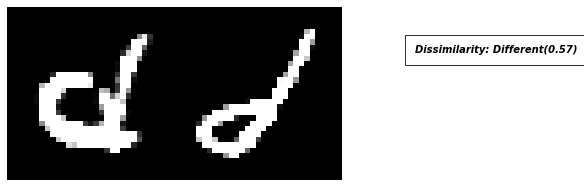

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


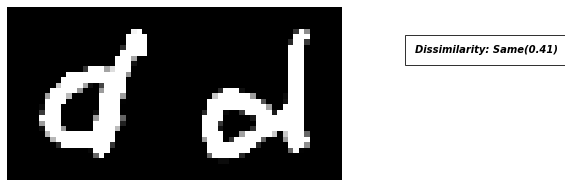

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


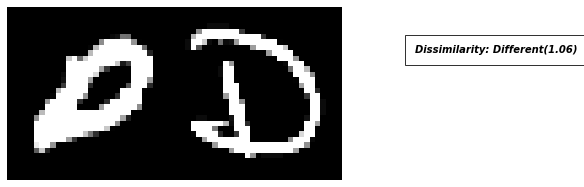

In [ ]:

#TOGGLELE BETWEEN SIMILAR AND DIFFERENT IMAGES TO SEE REALTIME PERFORMANCE OF MODEL ON UNSEEN CLASSES

toggle = 'same'



input_char = random.choice(setb)
if toggle == 'same':

  char1 = input_char
  char2 = input_char
elif toggle == 'different':
  char1 = random.choice(setb)
  char_bf = copy.deepcopy(setb)
  char_bf.pop(char_bf.index(char1))
  char2 = random.choice(char_bf)
  del char_bf

encoded1 = util.get_lbl_val(label_classes, [char1])[0]
encoded2 = util.get_lbl_val(label_classes, [char2])[0]
for i in range(40):    
    input0 = random.choice(req_dataset[encoded1])
    input1 = random.choice(req_dataset[encoded2])
    concatenated = torch.cat((input0,input1),0).cuda()
    embeddings = model(concatenated)
    i0_flip = torch.rot90(input0, 1, [3, 2])
    i0_flip = torchvision.transforms.RandomHorizontalFlip(1)(i0_flip)
    i1_flip = torch.rot90(input1, 1, [3, 2])
    i1_flip = torchvision.transforms.RandomHorizontalFlip(1)(i1_flip)
    concatenated_show = torch.cat((i0_flip,i1_flip),0)
    dists = _pairwise_distances(embeddings, squared=True, device=device)
    dist = dists.cpu().detach()
    if float(dists[0][1])> avg_intra_dist.avg:
      condition = 'Different'
    else:
      condition = 'Same'
    imshow(torchvision.utils.make_grid(concatenated_show),'Dissimilarity: ' + condition + '({0:.2f})'.format(dists[0][1]))

In [16]:
req_dataset = OrderedDict(req_dataset)
a_keys = req_dataset.keys()
a_vals = req_dataset.values()
res_actuals = itertools.combinations(a_vals,2)
list_res_actuals = []
for each in res_actuals:
     list_res_actuals.append(list(each))
res_labs = itertools.combinations(a_keys,2)
list_res_labels = []
for each in res_labs:
     list_res_labels.append(list(each))
for ind, x in enumerate(list_res_actuals):
    print(list_res_labels[x])
    for i in itertools.product(*pro):
        print (i)
    break

NameError: ignored

In [ ]:
#MEASURE ACCURACY METRIC BY SAMPLING WITHIN N ITERATIONS OF PAIRWISE COMPARISON

num_sample_pairs = 4000

all_preds = []
all_tar = []
right = 0

all_inputs = []
for i in req_dataset.keys():
  for j in req_dataset[i]:
    all_inputs.append(j)

half_len = len(all_inputs)//2
inputs1 = all_inputs[:half_len]
inputs_2 = all_inputs[half_len:]

for i in itertools.product(*[inputs1, inputs2]):





    for k in req_dataset.keys():
      for l in req_dataset[k]:
        input1, input2 = i
        input2 = l
        if i == k:
          target = 1
        else:
          target = 0
        concatenated = torch.cat((input0,input1),0).cuda()
        embeddings = model(concatenated)
        dists = Mining._pairwise_distances(embeddings, squared=True, device=device)
        dist = dists.cpu().detach()
        if float(dists[0][1])> avg_intra_dist.avg:
          prediction = 0
        else:
          prediciton = 1       
        all_tar.append(target)
        all_preds.append(prediction)
        if target == prediction:
          right +=  1
        if len(all_tar)>num_sample_pairs:
          break     
print('Accuracy: ', right/len(all_tar))


Accuracy:  0.8305309734513274
